### **Student Information**
**Name: Tsegaye Semere**

**Student ID: 113162862**

**GitHub ID: https://github.com/tsegayesemere/DM2025-Lab2-Exercise**

**Kaggle name:Tsegaye Semere**

**Kaggle private scoreboard snapshot: ![pic_ranking.png](./pics/pic_ranking.png)**

---

***

# **Project Report**

### 1.1 Preprocessing Steps

**Step 1: Load all required files downloaded from the Kaggle competition page**
The following files are uploaded for processing:

* `data_identification.csv`
* `emotion.csv`
* `final_posts.json`

**Step 2: Converting the JSON file into CSV format**
For convenience during processing and alignment, all files should be in the same format—CSV.
Therefore, `final_posts.json` is converted into `posts.csv`.

**Step 3: Exploring the CSV files**
All three files are loaded and converted into dataframes.
The following columns are found in each dataframe:

* `emotion.csv` → **id, emotion**
* `data_identification.csv` → **id, split**
* `posts.csv` → **post_id, text**

Since `posts.csv` uses `post_id` instead of `id`, it is renamed to **id** to align the column names.

**Step 4: Creating a merged CSV file**
A combined CSV file, **Full_data_frame.csv**, is created containing:
**id, text, emotion, split**

This file is saved locally for future use.
`Full_data_frame.csv` is then re-uploaded to the notebook and loaded as a dataframe.

**Step 5: Creating train/test datasets**
Since `Full_data_frame.csv` includes both training and test data, it is split into two dataframes—**train_df** and **test_df**—based on the value in the `split` column.

**Step 6: Exploring the size of each dataframe**
The shapes of the resulting datasets are:

* **Training dataframe:** (47,890 rows, 3 columns)
* **Testing dataframe:** (16,281 rows, 2 columns)

Note: The size of the test dataframe matches the number of records found in the sample submission file from the Kaggle competition.

---


**Step 7: Text Preprocessing**

Emotions are subtle, so they shouldn't be over-cleaned. Because removing too much may reduces emotional signal.

**So the following preprocessing are carried out**

* Convert all text into lowercase
* Removing URLs, emails, HTML
* Normalizing spaces
* Handling repeated letters (“soooo” → “soo”)

**But the following are left untouched** 
* emojis because they carry strong emotion
* punctuation (!!!, ?!, etc.)
**Removal of most frequent words**
As indicated in the following graph few words dominated the dataframe and they are found in all emotion classes so removing them do not bias the prediction. therefore the following 15 words are removed from the dataset
<center>
<img src="./pics/frequency.png" width="500px">
</center>

 **Emotion class balancing**
 As indicated in the chart below the emotion classes are highly unbalanced.
<center>
<img src="./pics/class_size.png" width="350px">
</center>

 So class balance is done by down sampling joy and oversampling the rest to make them equal like the following
 <pre>target_sizes = {
    "joy": 20000
    "anger": 18000
    "surprise": 15000
    "sadness": 14000
    "fear": 13000
    "disgust": 12000
    }</pre>
 are removed like indicated inthe

### 1.2 Feature Engineering Steps

##### Embedding strategy

I evaluated multiple text-embedding methods because model performance is highly dependent on embedding quality. My experiments focused on two main options: **Ollama embeddings** and **BERTweet embeddings**. Each has unique strengths:

##### BERTweet Embedding
- Pretrained specifically on **Twitter data**, making it good for short, informal text.  
- Captures **slang, hashtags, abbreviations**, and noisy social-media patterns.  
- More domain-aware for posts with informal writing.

##### Ollama Embedding (nomic-embed-text)
- A **general-purpose embedding model** designed for semantic retrieval and classification.  
- Produces **dense, high-quality sentence embeddings** with strong semantic consistency.  
- More stable for long, varied text and less sensitive to noise.

##### My preference
In my experiments, **Ollama embeddings provided better downstream accuracy** for the emotion-classification model. They captured semantic meaning more consistently across all emotion classes, leading to stronger overall performance.

### 1.3 Explanation of my Model
**Step 1:**
##### Emotion Classification Using KNN

##### . Dataset Preparation
- Dataset `train_df` contains text embeddings and emotion labels.
- Split data into training (80%) and testing (20%) sets.
- Stratification used to maintain class distribution.

```python
from sklearn.model_selection import train_test_split

train_df_train, train_df_test = train_test_split(
    train_df,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=train_df["emotion"]  # preserve class distribution
)
```

##### . Features and Labels
- **Features (`X`)**: Text embeddings.
- **Labels (`y`)**: Emotion classes.

```python
X_train = train_df_train["embeddings"].tolist()
X_test = train_df_test["embeddings"].tolist()
y_train = train_df_train["emotion"]
y_test = train_df_test["emotion"]
```

##### . K-Nearest Neighbors (KNN) Model
- **Algorithm:** KNN
- **Parameters:** k=10, uniform weights, Euclidean distance (Minkowski p=2)
- **Characteristics:**
  - Instance-based, non-parametric classifier
  - Lazy learning: predictions rely on stored training data
  - Predicts majority emotion among k-nearest embeddings
  - Advantages: Simple, interpretable, works well with embeddings
  - Limitations: Sensitive to k and feature scaling; large datasets may slow predictions

```python
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
```

##### . Model Evaluation
- Evaluate test accuracy using KNN.

```python
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
```
**Step 2**
#### Emotion Classification Using Neural Networks with LLM Embeddings

##### . Label Encoding
- Emotion labels are converted into **one-hot vectors** suitable for neural network training.
- Both training and test labels are encoded.

##### . Input and Output Dimensions
- **Input shape:** Dimension of the text embeddings (e.g., 768).
- **Output shape:** Number of emotion classes (e.g., 6).
- Ensures the network's input and output layers match the dataset.

##### . Neural Network Architecture
- A **feedforward neural network** with:
  - Dense layers with 256 units
  - Batch normalization and ReLU activation
  - Dropout layers for regularization (e.g., 30%)
  - A residual connection to improve gradient flow
- Output layer uses **softmax** for multi-class emotion prediction.

##### . Training Strategy
- **Class weights** are computed to handle class imbalance, ensuring minority emotions are not underrepresented.
- The network is trained over multiple epochs with a defined batch size.
- A **CSV logger** records training progress.

##### . Evaluation Metrics
- Model performance is monitored using **accuracy** on the test set.
- Confusion matrices are used to **visualize prediction errors** and understand which emotions are commonly misclassified.

##### . Predictions on External Data
- The model can predict emotions for new text embeddings.
- Predicted labels are mapped back to original emotion names.
- Results can be exported to CSV for further analysis or submission.

##### . Performance Summary
- Achieved **~81% accuracy** on the test set.
- The model effectively captures semantic patterns from embeddings.
- Key considerations:
  - Handle class imbalance with weighted loss
  - Include regularization (dropout) to avoid overfitting
  - Residual connections improve stability and learning


---

### 2. Bonus Section (5 pts Optional)
**The original dataset word frequency viev**<br>
<img src="./pics/Befor.png" width="750px"> <br>
<img src="./pics/Befor_2.png" width="750px"><br>
**After agressive preprocessing, Actually the resulting model performance was so poor**<br>
<img src="./pics/After.png" width="750px"><br>
**Class size after balancing looks the following**<br>
<img src="./pics/balanced.png" width="750px"><br>
**Sample confusion matrix**<br>
<img src="./pics/cm.png" width="750px">

#### 2.1 What I have tried to improve my model's Classification Accuracy

I conducted several experiments to improve the performance of my emotion classification model. The steps and observations are summarized below:

1. **Baseline Training**
   - Trained the model **without any text preprocessing** or **class balancing**.
   - **Result:** Very poor performance.

2. **Removing Top Frequent Words**
   - Deleted the **30 most frequent words** after lowercasing text and removing punctuation.
   - Maintained the same class distribution.
   - **Result:** Performance remained poor.

3. **Frequency-Based Filtering and Downsampling**
   - Removed words with frequency higher than **10,000**.
   - **Downsampled the 'joy' class** to half of its original size.
   - **Result:** Improved performance; prediction quality increased.

4. **Class Balancing with Oversampling**
   - Applied similar text preprocessing as above.
   - Reduced 'joy' class size by half.
   - **Oversampled other classes** to match the reduced 'joy' size.
   - **Result:** Further improvement; test set predictions were better.

5. **Aggressive Oversampling**
   - Downsampled 'joy' by half and **oversampled it by 300%**.
   - Adjusted other classes to match the new 'joy' size.
   - **Result:** Achieved **90% accuracy** on the Jupyter notebook dataset (extraordinary), but performance **did not replicate** on the submission test set.

6. **Changing Embedding Model**
   - Switched from **Ollama embeddings** to **BERTTeet embeddings**.
   - Tried several configurations and parameter adjustments.
   - **Result:** No improvement; could not match Ollama’s performance.

7. **Parameter Tuning**
   - Experimented with epochs, train-test split ratios, and other hyperparameters.
   - **Result:** No significant improvement observed.
#### 2.2 Insights Gained
* Text preprocessing for emotion classification is different from preprocessing used in other NLP tasks.
For example, stemming, stop-word removal, and punctuation removal are common and often essential steps in tasks such as information retrieval.
However, in emotion classification, these elements carry important meaning, and removing them can degrade the performance of the prediction model.
* Emotion datasets collected from Twitter are very challenging because the language used is often informal and inconsistent. This makes text preprocessing more difficult. Moreover, there is a high degree of vocabulary overlap, where many words appear across all emotion classes. As a result, clustering this dataset has been one of the most challenging tasks I have encountered.
* Another challenge is the unbalanced class distribution across emotions (like the size differene between <b>disgust</b> and <b>joy</b>). I believe that using embeddings instead of raw text is a better approach to address this issue, as embeddings capture deeper semantic patterns and help the model generalize even when certain classes have fewer examples.

**Conclusion:**  
Text preprocessing and class balancing significantly affect model performance. However, embedding choice and dataset distribution remain crucial factors, as some improvements on internal validation may not transfer to the submission test set.


## 3. Model Implementation Steps

# **Competition Code**

## 1. Preprocessing Steps

**Step 1**

In [ ]:
import json
from pandas import json_normalize
import pandas as pd

emotion = pd.read_csv("data/phaseIII/emotion.csv")
split = pd.read_csv("data/phaseIII/data_identification.csv")
with open("data/phaseIII/final_posts.json", "r", encoding="utf-8") as f: # load the json file from my local drive
    post = json.load(f)

**Step 2**

In [ ]:
post = pd.DataFrame([
    {
        "post_id": item["root"]["_source"]["post"]["post_id"],
        "text": item["root"]["_source"]["post"]["text"]
    }
    for item in post
])

post.to_csv("data/phaseIII/posts.csv", index=False) # convert the json file in to csv for future use

**Step 3**

In [8]:
#load all csv files 
emotion = pd.read_csv("data/phaseIII/emotion.csv")
split = pd.read_csv("data/phaseIII/data_identification.csv")
post = pd.read_csv("data/phaseIII/posts.csv")

In [9]:
emotion.head()

,id,emotion
0,0x35663e,joy
1,0xc78afe,fear
2,0x90089c,joy
3,0x2ffb63,joy
4,0x989146,joy


In [10]:
split.head()

,id,split
0,0x61fc95,test
1,0x35663e,train
2,0xc78afe,train
3,0x90089c,train
4,0xaba820,test


In [11]:
post.head()

,post_id,text
0,0x61fc95,"We got the ranch, loaded our guns and sat up t..."
1,0x35663e,I bet there is an army of married couples who ...
2,0xc78afe,This could only end badly.
3,0x90089c,My sister squeezed a lime in her milk when she...
4,0xaba820,and that got my head bobbing a little bit.


In [12]:
# Rename post_id to id. Just for consistency
post.rename(columns={"post_id": "id"}, inplace=True)
post.head()

,id,text
0,0x61fc95,"We got the ranch, loaded our guns and sat up t..."
1,0x35663e,I bet there is an army of married couples who ...
2,0xc78afe,This could only end badly.
3,0x90089c,My sister squeezed a lime in her milk when she...
4,0xaba820,and that got my head bobbing a little bit.


**Step 4**

In [362]:
# merge the file in to one datafram (id,text,emotion,split)
import pandas as pd
#Full_data_frame = pd.merge(post, emotion, on='id', how='outer')
#Full_data_frame = pd.merge(Full_data_frame, split, on='id', how='outer')

#Full_data_frame.to_csv("data/phaseIII/Full_data.csv") # store the combined dataframe in local disk for future use
Full_data_frame = pd.read_csv("data/phaseIII/Full_data.csv") # Appload the saved combined dataframe
Full_data_frame.head()

,Unnamed: 0,id,text,emotion,split
0,0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",NaN,test
1,1,0x35663e,I bet there is an army of married couples who ...,joy,train
2,2,0xc78afe,This could only end badly.,fear,train
3,3,0x90089c,My sister squeezed a lime in her milk when she...,joy,train
4,4,0xaba820,and that got my head bobbing a little bit.,NaN,test


In [54]:
import pandas as pd
Full_data_frame = pd.read_csv("data/phaseIII/Full_data.csv") # Appload the saved combined dataframe

**Step 5**

In [55]:
# Splitting
test_df = Full_data_frame[Full_data_frame["split"] == "test"] # Separate the test split and train split in to different dataframes
train_df = Full_data_frame[Full_data_frame["split"] == "train"]

**Step 6**

In [56]:
# Size of dataframes
len(train_df)
len(test_df) # which should be equeal to the size of the sample submission data set

16281

# Text preprocessing
**Step 7**

In [57]:
# text preprocessing
import re
import pandas as pd
from bs4 import BeautifulSoup

# Function to clean text
def clean_text(text, lowercase=True, tokenize=False):
    # 1. Optional lowercase
    if lowercase:
        text = text.lower()

    # 2. Remove HTML tags
    text = BeautifulSoup(text, "lxml").get_text()

    # 3. Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # 4. Remove emails
    text = re.sub(r'\S+@\S+\.\S+', '', text)

    # 5. Reduce repeated letters (soooo → soo)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    return text

In [10]:
pip install beautifulsoup4


Note: you may need to restart the kernel to use updated packages.


In [58]:
from bs4 import BeautifulSoup
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)


/tmp/ipykernel_3862960/4017401276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['clean_text'] = train_df['text'].apply(clean_text)
/tmp/ipykernel_3862960/4017401276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['clean_text'] = test_df['text'].apply(clean_text)


In [12]:
##################################
#!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /home/tsegay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tsegay/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [59]:
#################################################
train_df["tokens"] = train_df["clean_text"].apply(word_tokenize)
test_df["tokens"] = test_df["clean_text"].apply(word_tokenize)

/tmp/ipykernel_3862960/4200272609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["tokens"] = train_df["clean_text"].apply(word_tokenize)
/tmp/ipykernel_3862960/4200272609.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["tokens"] = test_df["clean_text"].apply(word_tokenize)


In [64]:
########################################################
from nltk.util import ngrams
remove_words = {"i", "the", "is", "``"}   # use a set for speed

test_df["tokens"] = test_df["tokens"].apply(
    lambda tok_list: [w for w in tok_list if w.lower() not in remove_words]
)

/tmp/ipykernel_3862960/3935935863.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["tokens"] = test_df["tokens"].apply(


In [65]:
train_df["tokens"] = train_df["tokens"].apply(lambda x: " ".join(x))
test_df["tokens"] = test_df["tokens"].apply(lambda x: " ".join(x))

/tmp/ipykernel_3862960/4002054594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["tokens"] = train_df["tokens"].apply(lambda x: " ".join(x))
/tmp/ipykernel_3862960/4002054594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["tokens"] = test_df["tokens"].apply(lambda x: " ".join(x))


In [67]:
test_df.head(10)
#train_df["tokens"].apply(type).head()


,Unnamed: 0,id,text,emotion,split,clean_text,tokens
0,0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",NaN,test,we got the ranch loaded our guns and sat up ti...,we got ranch loaded our guns and sat up till s...
4,4,0xaba820,and that got my head bobbing a little bit.,NaN,test,and that got my head bobbing a little bit.,and that got my head bobbing a little bit .
5,5,0x66e44d,Same. Glad it's not just out store.,NaN,test,same. glad it's not just out store.,same . glad it 's not just out store .
6,6,0xc03cf5,Like always i will wait and see thanks for the...,NaN,test,like always i will wait and see thanks for the...,like always will wait and see thanks for post ...
8,8,0x02f65a,"There's a bit of room between ""not loving sub-...",NaN,test,"there's a bit of room between ""not loving sub-...",there 's a bit of room between `` not loving s...
16,16,0x479407,Okay I can see this looking really cool for a ...,NaN,test,okay i can see this looking really cool for a ...,okay can see this looking really cool for a fe...
20,20,0xe07a21,I screamed the chest pain was so bad i clutche...,NaN,test,i screamed the chest pain was so bad i clutche...,screamed chest pain was so bad clutched my che...
27,27,0x06d186,Fuck I love you prag,NaN,test,fuck i love you prag,fuck love you prag
29,29,0xa9a658,"After this, I understand why outside Guangdong...",NaN,test,after this i understand why outside guangdong ...,after this understand why outside guangdong al...
41,41,0x0a0102,Having a baby born too soon is #lifechanging 6...,NaN,test,having a baby born too soon is #lifechanging 6...,having a baby born too soon # lifechanging 6 y...


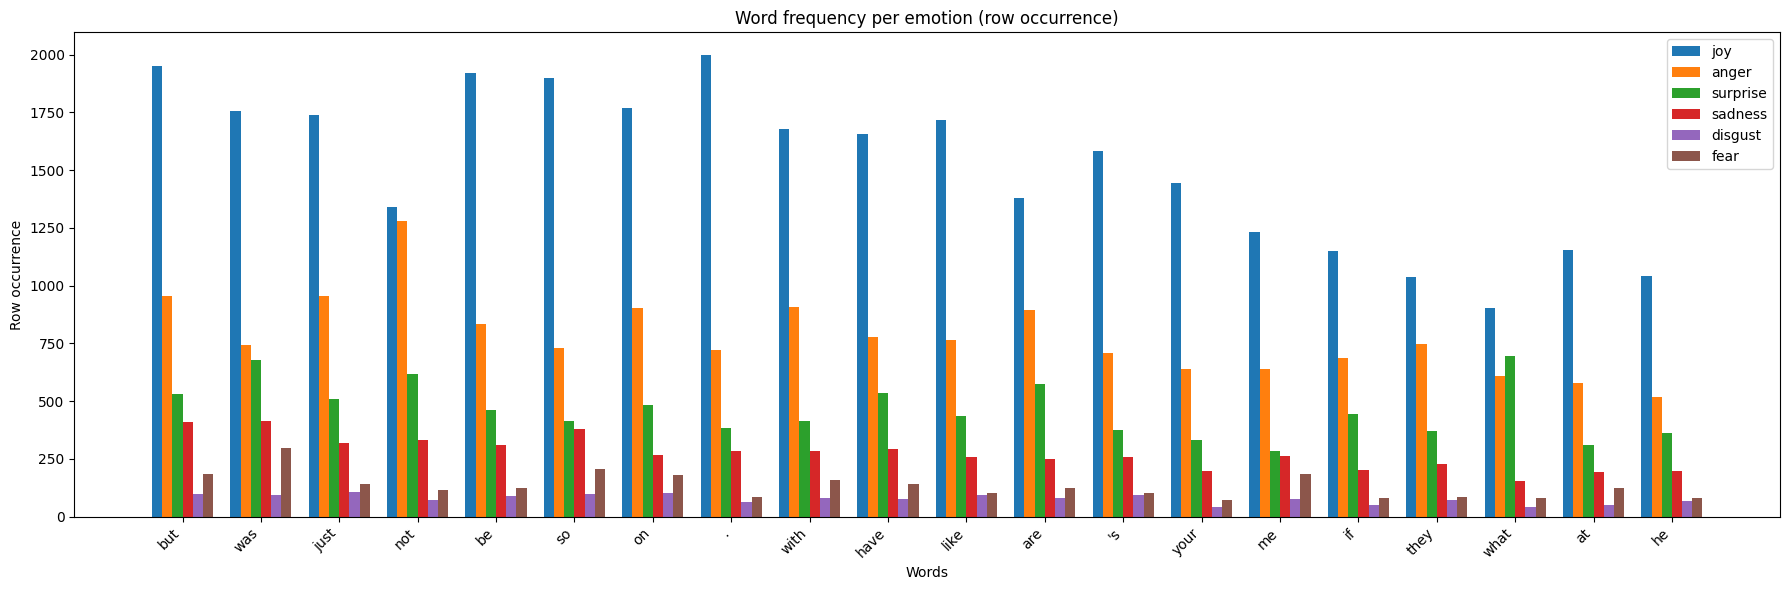

In [51]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Initialize dictionary for counts
word_emotion_counts = defaultdict(lambda: defaultdict(int))

for _, row in train_df.iterrows():
    words = set(row['clean_text'].split())  # Count row occurrence only once
    emotion = row['emotion']
    for word in words:
        word_emotion_counts[word][emotion] += 1

# Step 2: Convert to DataFrame
word_emotion_df = pd.DataFrame(word_emotion_counts).T.fillna(0).astype(int)

# Step 3: Pick top N words across all emotions
top_n = 20
# Sum across emotions to get most common words
top_words = word_emotion_df.sum(axis=1).sort_values(ascending=False).head(top_n)
top_word_df = word_emotion_df.loc[top_words.index]

# Step 4: Plot grouped bar chart
emotions = top_word_df.columns.tolist()
x = np.arange(len(top_word_df))  # the label locations
width = 0.13  # width of each bar

plt.figure(figsize=(18, 6))

for i, emotion in enumerate(emotions):
    plt.bar(x + i*width, top_word_df[emotion], width=width, label=emotion)

plt.xlabel('Words')
plt.ylabel('Row occurrence')
plt.title('Word frequency per emotion (row occurrence)')
plt.xticks(x + width*len(emotions)/2 - width/2, top_word_df.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [245]:
def remove_word(text):
    text = text.replace("[name]","")
    return text
train_df['clean_text'] = train_df['clean_text'].apply(remove_word)
test_df['clean_text'] = test_df['text'].apply(remove_word)

**Class imbalance**

In [70]:
import pandas as pd

df = train_df.copy()

# Target sizes
target_sizes = {
    "joy": 20000,
    "anger": 18000,
    "surprise": 15000,  # unchanged
    "sadness": 14000,
    "fear": 12000,
    "disgust": 13000
}

balanced_parts = []

for emotion, target in target_sizes.items():
    subset = df[df["emotion"] == emotion]
    
    if target < len(subset):
        # UNDERSAMPLE
        new_subset = subset.sample(target, replace=False, random_state=42)
    elif target > len(subset):
        # OVERSAMPLE
        new_subset = subset.sample(target, replace=True, random_state=42)
    else:
        # EXACT SAME SIZE
        new_subset = subset
    
    balanced_parts.append(new_subset)

# Combine new dataset
df_balanced = pd.concat(balanced_parts).reset_index(drop=True)

# Check new distribution
print(df_balanced["emotion"].value_counts())


emotion
joy         20000
anger       18000
surprise    15000
sadness     14000
disgust     13000
fear        12000
Name: count, dtype: int64


In [71]:
train_df = df_balanced

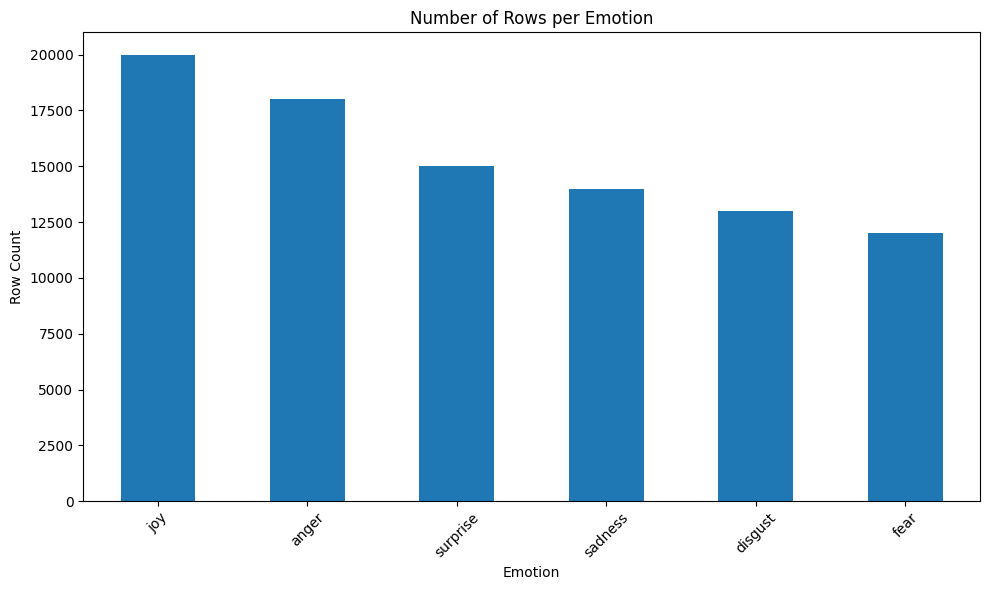

In [72]:
import matplotlib.pyplot as plt

# Count rows per emotion
emotion_counts = train_df["emotion"].value_counts()

# Plot
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')

plt.xlabel("Emotion")
plt.ylabel("Row Count")
plt.title("Number of Rows per Emotion")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Feature Extruction

In [73]:
'''from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load BERTweet (base)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
model = AutoModel.from_pretrained("vinai/bertweet-base")


def generate_bertweet_embedding(text):
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # Use mean pooling to get sentence embedding
    last_hidden = outputs.last_hidden_state  # shape: (batch, seq_len, hidden)
    attention_mask = inputs['attention_mask'].unsqueeze(-1)  # shape: (batch, seq_len, 1)
    
    # Apply mask before averaging
    masked_hidden = last_hidden * attention_mask
    summed = masked_hidden.sum(dim=1)  # sum across sequence
    counts = attention_mask.sum(dim=1)  # number of valid tokens
    embedding = summed / counts         # mean pooling
    
    return embedding.squeeze().numpy()



def generate_bertweet_embeddings(row, text_column_name='clean_text'):
    text = row[text_column_name]
    return generate_bertweet_embedding(text)


'''

import ollama
def generate_embeddings(row,text_column_name='tokens'):
    embeddings = ollama.embeddings(
        model='nomic-embed-text',
        prompt=row[text_column_name],
    )
    return embeddings["embedding"]

In [74]:
'''def generate_bertweet_embeddings(row, text_column_name='clean_text'):
    text = row[text_column_name]
    return generate_bertweet_embedding(text)
'''

"def generate_bertweet_embeddings(row, text_column_name='clean_text'):\n    text = row[text_column_name]\n    return generate_bertweet_embedding(text)\n"

In [75]:
# Append embeddings column to train_df

train_df['embeddings'] = train_df.apply(generate_embeddings, axis=1)


'''train_df["embeddings"] = train_df.apply(
    generate_bertweet_embeddings,
    axis=1
)
'''

'train_df["embeddings"] = train_df.apply(\n    generate_bertweet_embeddings,\n    axis=1\n)\n'

In [76]:
'''test_df['embeddings'] = test_df.apply(
    generate_bertweet_embeddings,
    axis=1
)'''
test_df['embeddings'] = test_df.apply(generate_embeddings, axis=1)

/tmp/ipykernel_3862960/2577393114.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['embeddings'] = test_df.apply(generate_embeddings, axis=1)


In [77]:
# Filter only those rows which has 768 dimensions only 
train_df = train_df[train_df["embeddings"].apply(lambda x: len(x) == 768)]
train_df = train_df.reset_index(drop=True)
test_df = test_df[test_df["embeddings"].apply(lambda x: len(x) == 768)]
test_df = test_df.reset_index(drop=True)

# Model Description

In [78]:
from sklearn.model_selection import train_test_split

train_df_train, train_df_test = train_test_split(
    train_df,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=train_df["emotion"]   # keeps class distribution balanced
)


In [79]:
import numpy as np
X_embgemma_train = np.vstack(train_df_train["embeddings"].to_numpy()) #Defining our train set
X_embgemma_test = np.vstack(train_df_test["embeddings"].to_numpy()) #Defining our test set

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Let's use the new embeddinggemma embeddings as our training features and the emotions as our labels
##X_train = df_train_train["embeddings"].tolist()
X_train = train_df_train["embeddings"].tolist()

y_train = train_df_train['emotion']

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)

,n_neighbors,10
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [81]:
X_test = train_df_test["embeddings"].tolist()
y_test = train_df_test['emotion']

# Predicting the label for the test data
y_pred = knn.predict(X_test)

#Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'KNN Accuracy: {accuracy}')


KNN Accuracy: 0.6507065217391305


In [82]:
# deal with label (string -> one-hot)
import keras
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:6]:\n', y_train[0:6])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)


check label:  ['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']

## Before convert
y_train[0:6]:
 65610    sadness
54578    sadness
32051      anger
57808    sadness
18005        joy
74548       fear
Name: emotion, dtype: object

y_train.shape:  (73600,)
y_test.shape:  (18400,)


In [83]:
#One-hot encoding our labels
##y_train = df_train_train["emotion"]
y_train = train_df_train["emotion"]

y_test  = train_df_test["emotion"]
y_train_embgemma = label_encode(label_encoder, y_train)  
y_test_embgemma = label_encode(label_encoder, y_test)

In [84]:
# I/O check
input_shape_embgemma = len(X_embgemma_train[0])
print('input_shape: ', input_shape_embgemma)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)


input_shape:  768
output_shape:  6


In [85]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # disable GPU (fix cuInit error)

from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Add

inp = Input(shape=(input_shape_embgemma,))

# Block 1
h = Dense(256)(inp)
h = BatchNormalization()(h)
h = ReLU()(h)
h = Dropout(0.3)(h)

# Residual block
r = Dense(256)(h)
r = BatchNormalization()(r)
r = ReLU()(r)
r = Dropout(0.3)(r)

x = Add()([h, r])

# Output
out = Dense(output_shape, activation="softmax")(x)

model = Model(inp, out)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [86]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = label_encoder.classes_
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log_2_ts2.csv')

# training setting
epochs = 30
batch_size = 32

class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(class_weight_dict)
history = model.fit(
    X_embgemma_train, y_train_embgemma,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_embgemma_test, y_test_embgemma),
    class_weight=class_weight_dict
)


{0: np.float64(0.8518518518518519), 1: np.float64(1.1794871794871795), 2: np.float64(1.2777777777777777), 3: np.float64(0.7666666666666667), 4: np.float64(1.0952380952380953), 5: np.float64(1.0222222222222221)}
Epoch 1/30
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5466 - loss: 1.2085 - val_accuracy: 0.6669 - val_loss: 0.9252
Epoch 2/30
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6566 - loss: 0.9022 - val_accuracy: 0.7402 - val_loss: 0.7441
Epoch 3/30
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7116 - loss: 0.7497 - val_accuracy: 0.7875 - val_loss: 0.6249
Epoch 4/30
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7472 - loss: 0.6547 - val_accuracy: 0.8149 - val_loss: 0.5545
Epoch 5/30
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7744 - loss: 0.5790 - val_accuracy: 0.8296 - val_loss: 0.5110
Epoch 6/30
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7945 - loss: 0.5295 - val_accuracy: 0.8486 - val_loss: 0.4641
Epoch 7/3

In [87]:
pred_result = model.predict(X_embgemma_test, batch_size=128)
pred_result[:5]
pred_result = label_decode(label_encoder, pred_result)
pred_result[:10]

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array(['joy', 'sadness', 'fear', 'sadness', 'sadness', 'anger', 'anger',
       'fear', 'joy', 'joy'], dtype=object)

In [88]:
# Funciton for visualizing confusion_matrix
import itertools
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()


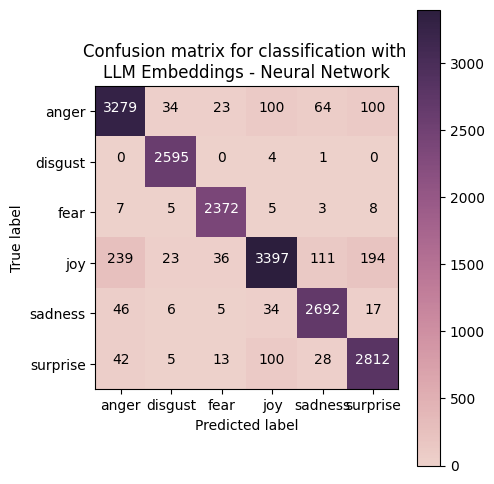

In [89]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm3 = confusion_matrix(y_true=label_decode(label_encoder, y_test_embgemma), y_pred=pred_result) 
my_tags = ['anger','disgust', 'fear', 'joy', 'sadness','surprise']
plot_confusion_matrix(cm3, classes=my_tags, title='Confusion matrix for classification with \nLLM Embeddings - Neural Network')


In [90]:
testt_df = test_df[test_df["embeddings"].apply(lambda x: len(x) == 768)]
testt_df = testt_df.reset_index(drop=True)
X_test = np.vstack(testt_df["embeddings"].values)
pred_probs = model.predict(X_test)
id2label = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "joy",
    4: "sadness",
    5: "surprise"
}
pred_indices = np.argmax(pred_probs, axis=1)

import numpy as np

# Convert embeddings to proper 2D array
X_test = np.vstack(testt_df['embeddings'].to_numpy())

# Make predictions
pred_probs = model.predict(X_test)               # shape: (num_samples, num_classes)
pred_classes = np.argmax(pred_probs, axis=1)     # get class indices

# Map back to original emotion labels
testt_df['emotion'] = label_encoder.inverse_transform(pred_classes)

# Check first few rows
final = testt_df[['id','emotion']]
#final.to_csv("submission_9.csv")


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


In [91]:
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test_embgemma), pred_result), 2)))

testing accuracy: 0.93


In [92]:
final.to_csv("submission_atmp_7.csv")